# Multimodal Media Analysis by Amazon Sagemaker's multi-container endpoints
### Post by Venugopal Pai


Internet memes are deeply ingrained in social media platforms such as Facebook, Instagram, and Twitter and a deeper analysis of their symbolic meaning helps us to understand the opinion of a community. The nature of the way Internet memes can be spread allows them to be a way for members of specific communities to communicate and identify with one another but on the flipside, it can become a tool for malicious users to spread hatred and provoke targeted entities. 

This notebook uses the Kaggle dataset - https://www.kaggle.com/williamscott701/memotion-dataset-7k to analyse and classify Internet memes based on the type of humour i.e.sarcasm, offensive, motivational and understand the overall sentiment. The dataset contains human annotated tags of sentiment and humour for each of the images. 

I have used Amazon Sagemaker's multi-container endpoint with direct invocation to deploy Amazon's Image Classification model and BlazingText model and ensembled the individual predictions using averaging from each model to arrive at the final prediction for evaluation. The datasets present a multilabel multiclass classification problem and I have used augmented file format to load the dataset using RecordIO wrapper and "class-id" label formating for training the individual models.

This example can be extended in several ways such as picking a different model for training, bringing your own custom model, training a separate model for peforming the ensemble instead of a taking a simple average.


---
## Creating the ML models in Amazon SageMaker

In this example notebook, I have created two models—a multilabel image classification model and a multilabel supervised text classification model - and ensembled the outputs. The multi-label multi-class classification will classify the  Internet meme based on Humour, Sarcasm, Offensive, Motivational and Overall Sentiment. 

Here are the high-level steps we will follow to for this example:

   * Prepare your Amazon SageMaker Jupyter notebook.
   * Analyse the dataset - includes jpeg encoding & resizing the images and cleaning the text
   * Load a dataset from Amazon Simple Storage Service (S3) using Amazon SageMaker.
   * Build a model using the Amazon Image Classification algorithm.
   * Build a model using the Amazon BlazingText algorithm.
   * Host the containers on Amazon SageMaker on a single endpoint to make ongoing predictions.
   * Generate final predictions on the test data set.


![architecture](SagemakerMultiContainer.png "Architecture")

## Setup

Let's start by specifying:

* Specify the Amazon SageMaker role Amazon Resource Name (ARN) used to give learning and hosting access to your data. 
* Specify the Amazon S3 bucket that will be used for training and storing model objects.

In [9]:
import sagemaker
from sagemaker.amazon.amazon_estimator import get_image_uri
import boto3
import os 
import urllib.request
import json
import sys
!pip3 install Pillow
!pip3 install kaggle
 
region = boto3.Session().region_name    

role = sagemaker.get_execution_role()
s3 = boto3.client('s3')
smclient = boto3.client(service_name='sagemaker')

     |████████████████████████████████| 58 kB 6.8 MB/s  eta 0:00:01
     |████████████████████████████████| 75 kB 5.5 MB/s  eta 0:00:01
     |████████████████████████████████| 78 kB 9.3 MB/s  eta 0:00:01
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73053 sha256=9299ee563412e432ae3339b4afbb7ed13be3c99e187c9d9dd8fcdf0bda9426cf
  Stored in directory: /home/ec2-user/.cache/pip/wheels/77/47/e4/44a4ba1b7dfd53faaa35f59f1175e123b213ff401a8a56876b
Successfully built kaggle


Now you need to import the relevant Python libraries that we’ll use throughout the analysis.

In [6]:
import numpy as np                                # For matrix operations and numerical processing
import pandas as pd                               # For munging tabular data
from random import shuffle
import multiprocessing
from multiprocessing import Pool
import csv
import nltk
import re
import string
import itertools
from sklearn import metrics
import matplotlib.pyplot as plt
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Let’s define the Amazon S3 bucket used for the example.

In [7]:
bucket = sagemaker.Session().default_bucket()
prefix = 'sagemaker/Memotion_Analysis'
prefix_img = prefix + '/' + 'imageclassification'
prefix_txt = prefix + '/' + 'blazingtext'

## Data

Images are placed in memotion_dataset_7k/images folder and are a mix of JPG and PNG files. The 'labels_pd_pickle' and labels.csv file contains all the image file names and labels in pickled and csv format respectively. The 'reference_df_pickle' file contains the internet links of the image files

## Prepare: 

To get the data into Amazon S3 in a format that ImageClassification and BlazingText can read, I extracted the relevant files from the zipped file, create an augmented manifest file for image and text, and added them to the Amazon S3 bucket so that S3 and Amazon SageMaker can read them.

In [15]:
%%bash
mkdir ~/.kaggle
cp /home/ec2-user/SageMaker/kaggle.json ~/.kaggle/kaggle.json
sudo chmod 600 ~/.kaggle/kaggle.json

#### Extract Files and Read Data Pre-Conversion

In [16]:
!kaggle datasets download -d williamscott701/memotion-dataset-7k
!unzip -q memotion-dataset-7k.zip
image_dir = './memotion_dataset_7k/images'


 99%|████████████████████████████████████████▌| 689M/695M [00:07<00:00, 139MB/s]
100%|████████████████████████████████████████| 695M/695M [00:07<00:00, 97.5MB/s]


####  Read Data Pre-Conversion

In [17]:
import pandas as pd
df = pd.read_pickle("./memotion_dataset_7k/labels_pd_pickle")
df.head()

,image_name,text_ocr,text_corrected,humour,sarcasm,offensive,motivational,overall_sentiment
0,image_1.jpg,LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...,LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...,hilarious,general,not_offensive,not_motivational,very_positive
1,image_2.jpeg,The best of #10 YearChallenge! Completed in le...,The best of #10 YearChallenge! Completed in le...,not_funny,general,not_offensive,motivational,very_positive
2,image_3.JPG,Sam Thorne @Strippin ( Follow Follow Saw every...,Sam Thorne @Strippin ( Follow Follow Saw every...,very_funny,not_sarcastic,not_offensive,not_motivational,positive
3,image_4.png,10 Year Challenge - Sweet Dee Edition,10 Year Challenge - Sweet Dee Edition,very_funny,twisted_meaning,very_offensive,motivational,positive
4,image_5.png,10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...,10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...,hilarious,very_twisted,very_offensive,not_motivational,neutral


In [18]:
df = df.drop(columns = ['text_ocr'])   # dropping text_ocr column as we will use text_corrected column

We check if any of the columns have null values

In [19]:
df[df.isnull().any(axis=1)]

,image_name,text_corrected,humour,sarcasm,offensive,motivational,overall_sentiment
119,image_120.jpg,NaN,not_funny,general,not_offensive,not_motivational,positive
4799,image_4800.jpg,NaN,very_funny,general,slight,motivational,neutral
6781,image_6782.jpg,NaN,very_funny,twisted_meaning,not_offensive,not_motivational,positive
6784,image_6785.jpg,NaN,hilarious,general,not_offensive,not_motivational,positive
6786,image_6787.jpg,NaN,not_funny,not_sarcastic,very_offensive,motivational,positive


In [20]:
df.isnull().any()

image_name           False
text_corrected        True
humour               False
sarcasm              False
offensive            False
motivational         False
overall_sentiment    False
dtype: bool

Drop all the rows that have null values

In [21]:
df.dropna(inplace=True)
df.isnull().any()

image_name           False
text_corrected       False
humour               False
sarcasm              False
offensive            False
motivational         False
overall_sentiment    False
dtype: bool

#### Conversion
We resize all the images to (224,224) and convert them to JPEG as Image Classification algorithm accepts all images in JPEG format. We enabled loading of truncated images files. Functions 'isPNGfile' validate if the image file is of PNG format and 'changePNGextntoJPG' converts the png extension to jpg. This will useful while uploading the right images to S3

In [22]:
#importing the required package
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
newsize = (224, 224)


def useResizedJPEGImages(basepath, filename):
    k = filename.rfind(".")
    filename_without_extn = filename[:k]
    extn = filename[k:]
    filepath = basepath + '/' + filename_without_extn + extn
    img = Image.open(filepath)
    rgb_im = img.convert("RGB")
    resize_im = rgb_im.resize(newsize)
    
    if extn == '.png' or extn == '.PNG':
        filepath = basepath + '/' + filename_without_extn + '.jpg'
    
    rgb_im.save(filepath)
    return filepath
    
    
def isPNGfile(filepath):
    k = filepath.rfind(".")
    extn = filepath[k:]
    if extn == '.png' or extn == '.PNG':
        return True
    else:
        return False

def changePNGextntoJPG(filepath):
    if isPNGfile(filepath) == True:
        k = filepath.rfind(".")
        filename_without_extn = filepath[:k]
        return filename_without_extn + '.jpg'
        

In [23]:
# itrate over files in
# that directory
for filename in os.listdir(image_dir):
    f = os.path.join(image_dir, filename)
    # checking if it is a file
    if os.path.isfile(f):
        useResizedJPEGImages(image_dir, filename)

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/PIL/Image.py:963: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


We perform label encoding to store the labels in categorical order. We use these labels while building the confusion matrix

In [24]:
df['humour'] = df['humour'].astype('category')
df['sarcasm']= df['sarcasm'].astype('category')
df['offensive']= df['offensive'].astype('category')
df['motivational']= df['motivational'].astype('category')
df['overall_sentiment']= df['overall_sentiment'].astype('category')


df['humour_cat'] = df['humour'].cat.codes
df['sarcasm_cat'] = df['sarcasm'].cat.codes
df['offensive_cat'] = df['offensive'].cat.codes
df['motivational_cat'] = df['motivational'].cat.codes
df['overall_sentiment_cat'] = df['overall_sentiment'].cat.codes
df.head()

,image_name,text_corrected,humour,sarcasm,offensive,motivational,overall_sentiment,humour_cat,sarcasm_cat,offensive_cat,motivational_cat,overall_sentiment_cat
0,image_1.jpg,LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...,hilarious,general,not_offensive,not_motivational,very_positive,1,0,1,1,4
1,image_2.jpeg,The best of #10 YearChallenge! Completed in le...,not_funny,general,not_offensive,motivational,very_positive,2,0,1,0,4
2,image_3.JPG,Sam Thorne @Strippin ( Follow Follow Saw every...,very_funny,not_sarcastic,not_offensive,not_motivational,positive,3,1,1,1,2
3,image_4.png,10 Year Challenge - Sweet Dee Edition,very_funny,twisted_meaning,very_offensive,motivational,positive,3,2,3,0,2
4,image_5.png,10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...,hilarious,very_twisted,very_offensive,not_motivational,neutral,1,3,3,1,1


## Exploration

Now we’ll explore the dataset to understand the size of data, the various fields, the values that different features take, and the distribution of target values.                                          

### Data exploration and transformations

For an effective ML model and potentially for higher accuracy, the more data the better. Since the dataset we’re using in this blog post is quite limited, I didn’t remove any features. This methodology can be applied for larger data sets.

### Data Histograms and Correlation

Here we can visualize the data to see the spread of data within each feature in a histogram and scatter matrix. The scatter-plot matrix displays the correlation between pairs of variables. The matrix makes it easy to look at all pairwise correlations in one place.

,humour_cat,sarcasm_cat,offensive_cat,motivational_cat,overall_sentiment_cat
count,6987.000000,6987.000000,6987.000000,6987.000000,6987.000000
mean,1.525118,0.832546,1.758552,0.647202,1.865035
std,1.261554,0.959387,0.816001,0.477875,1.088401
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,0.000000,1.000000
50%,2.000000,0.000000,2.000000,1.000000,2.000000
75%,3.000000,2.000000,2.000000,1.000000,2.000000
max,3.000000,3.000000,3.000000,1.000000,4.000000


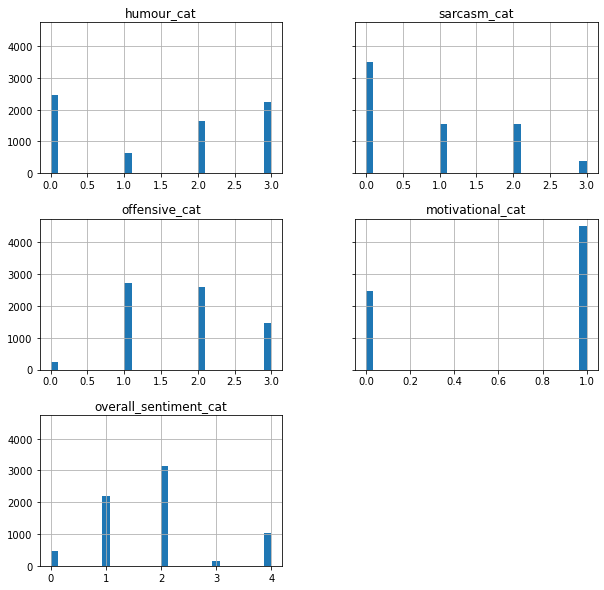

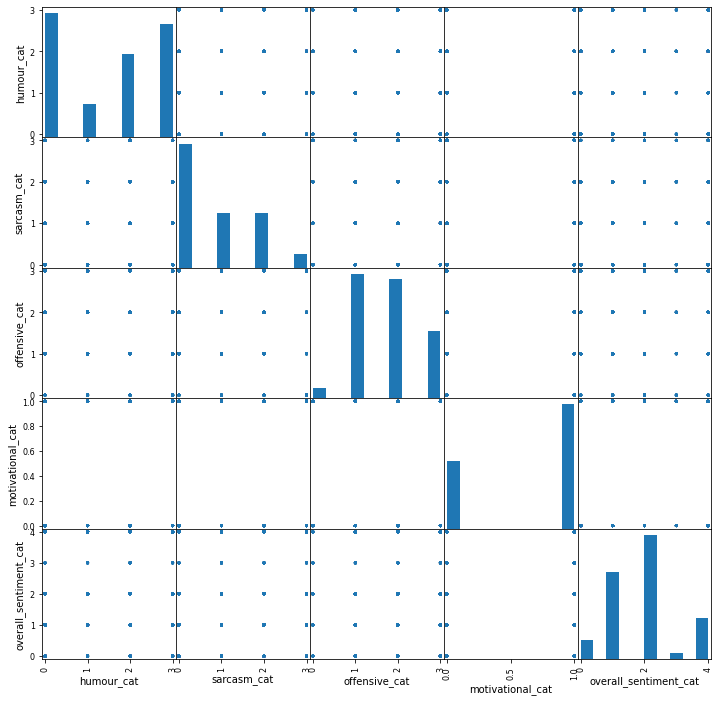

In [25]:
# Histograms for each numeric features
display(df.describe())
%matplotlib inline
hist = df.hist(bins=30, sharey=True, figsize=(10, 10))

##correlation

pd.plotting.scatter_matrix(df,figsize=(12, 12))
plt.show()

### Data Description
Let's talk about the data.  At a high level, we can see:

* There are 9 columns and around 6992 rows in the raw data set
* There are five classes - 'humour', 'sarcasm', 'offensive', 'motivational' & 'overall_sentiment' and each of these labels have multiple labels
* 'Humour' -> hilarious, very_funny, funny, not_funny
* 'Sarcasm' -> not_sarcastic, general, twisted_meaning, very_twisted
* 'Offensive' -> not_offensive, slight, very_offensive, hateful_offensive
* 'Motivational' -> motivational, motivational
* 'Overall Sentiment' -> very_positive, positive, neutral, negative, very_negative

_**Specifics on the features:**_ 
* 5 out of 5 features are categorical

**Target variable:**
* Identify the category in each of the classes

In [26]:
humour_classes = ['Funny','Hilarious','Not Funny', 'Very Funny']
sarcasm_classes = ['General','Not Sarcastic', 'Twisted Meaning', 'Very Twisted']
offensive_classes = ['Hateful Offensive', 'Not Offensive', 'Slight', 'Very Offensive']
motivational_classes = ['Motivational', 'Not Motivational']
sentiment_classes = ['Negative', 'Neutral', 'Positive', 'Very Negative', 'Very Positive']


In [27]:
def humourcode(value):
    if value == 'funny':
        return 0
    elif value == 'hilarious':
        return 1
    elif value == 'not_funny':
        return 2
    else :
        return 3
    
def sarcasmcode(value):
    if value == 'general':
        return 4
    elif value == 'not_sarcastic':
        return 5
    elif value == 'twisted_meaning':
        return 6
    else : 
        return 7

def offensivecode(value):
    if value == 'hateful_offensive':
        return 8
    elif value == 'not_offensive':
        return 9
    elif value == 'slight':
        return 10
    else :
        return 11

def motivationalcode(value):
    if value == 'motivational':
        return 12
    else :
        return 13

def sentimentcode(value):
    if value == 'negative':
        return 14
    elif value == 'neutral':
        return 15
    elif value == 'positive':
        return 16
    elif value == 'very_negative':
        return 17
    else:
        return 18

In [28]:
def getcode(row):
    code = []
    humour = humourcode(row['humour'])
    sarcasm = sarcasmcode(row['sarcasm'])
    offensive = offensivecode(row['offensive'])
    mot = motivationalcode(row['motivational'])
    sentiment = sentimentcode(row['overall_sentiment'])
    
    code.append(humour)
    code.append(sarcasm)
    code.append(offensive)
    code.append(mot)
    code.append(sentiment)
    return code

In [29]:
def upload_to_s3(channel, filepath, filename):
    s3 = boto3.resource('s3')
    data = open(filepath, "rb")
    key = channel + '/' + filename
    s3.Bucket(bucket).put_object(Key=key, Body=data)

Split the data into 80% training, 10% validation and 10% training data


In [30]:
# Let's split to data into training (80%), validation (10%) and test (10%) subsets.
train_indices = np.arange(0, int(0.8*len(df)))
val_indices = np.arange(int(0.8*len(df)), int(0.9*len(df)))
test_indices = np.arange(int(0.9*len(df)), int(1.0*len(df)))

train_df = df.iloc[train_indices]
val_df = df.iloc[val_indices]
test_df = df.iloc[test_indices]


num_training_samples = len(train_df)
num_val_samples = len(val_df)
num_test_samples = len(test_df)

print("Number of training samples = " + str(num_training_samples))
print("Number of validation samples = " + str(num_val_samples))
print("Number of testing samples = " + str(num_test_samples))


Number of training samples = 5589
Number of validation samples = 699
Number of testing samples = 699


---

## Image Classification Training

For our first training algorithm we use the Image classification algorithm. The Amazon SageMaker image classification algorithm is a supervised learning algorithm that supports multi-label classification. It takes an image as input and outputs one or more labels assigned to that image. It uses a convolutional neural network (ResNet) that can be trained from scratch or trained using transfer learning when a large number of training images are not available. 

First we’ll need to specify training parameters. These include the following:

   * Our training job name
   * The image-classification algorithm container
   * Training instance type and count
   * S3 location for training data
   * S3 location for output data
   * Algorithm hyperparameters

The supported training input format is jpeg. We use Augmented File format for serving the inputs - Augmented file format contains 'source-ref' that contains the path to the image in S3 and 'class' is a list of labels in the 'class-id' format. The inputs are wrapped in RecordIO format.

In [31]:
training_image = get_image_uri(region, 'image-classification', repo_version="latest")
print (training_image)

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: latest.


811284229777.dkr.ecr.us-east-1.amazonaws.com/image-classification:1


In [32]:
# Four channels: train, validation, train_lst, and validation_lst
s3_train_key = prefix_img + '/train'
s3_validation_key = prefix_img + '/validation'
s3train_lst_key = prefix_img + '/train_lst'
s3validation_lst_key = prefix_img + '/validation_lst'
s3train = 's3://{}/{}/train/'.format(bucket, prefix_img)
s3validation = 's3://{}/{}/validation/'.format(bucket, prefix_img)
s3train_lst = 's3://{}/{}/train_lst/'.format(bucket, prefix_img)
s3validation_lst = 's3://{}/{}/validation_lst/'.format(bucket, prefix_img)

train_lst_path = './memotion_dataset_7k/train_image.manifest'
val_lst_path = './memotion_dataset_7k/validate_image.manifest'

Create Augmented file format for the training dataset

In [33]:
#{"source-ref": "s3://mybucket/sample01/image1.jpg", "class": "[2, 4, 12]"}

with open(train_lst_path,mode='a',encoding='utf-8') as f:
    for index, row in train_df.iterrows():
        code = getcode(row)         
        path = ''
        if isPNGfile(row['image_name']) == True:
            jpgfilename = changePNGextntoJPG(row['image_name'])
            path = s3train + jpgfilename
        else:
            path = s3train + row['image_name']
        data_set = {"source-ref": str(path), "class": str(code)}
        json_str = json.dumps(data_set,ensure_ascii=False)
        f.write(json_str + '\n')  

Create Augmented file format for the validation dataset

In [34]:
with open(val_lst_path,mode='a',encoding='utf-8') as valf:
    for index, row in val_df.iterrows():
        code = getcode(row)
        path = ''
        if isPNGfile(row['image_name']) == True:
            jpgfilename = changePNGextntoJPG(row['image_name'])
            path = s3validation + jpgfilename
        else:
            path = s3validation + row['image_name']

        data_set = {"source-ref": str(path), "class": str(code)}
        json_str = json.dumps(data_set,ensure_ascii=False)
        valf.write(json_str + '\n')  

Upload the images to S3 - we only upload the jpg files to S3

In [35]:
for index, row in train_df.iterrows():
    if isPNGfile(row['image_name']) == True:
        jpgfilename = changePNGextntoJPG(row['image_name'])
        filepath = image_dir + '/' + jpgfilename
        upload_to_s3(s3_train_key,filepath,jpgfilename)
    else:
        filepath = image_dir + '/' + row['image_name']
        upload_to_s3(s3_train_key,filepath,row['image_name'])

In [36]:
for index, row in val_df.iterrows():
    if isPNGfile(row['image_name']) == True:
        jpgfilename = changePNGextntoJPG(row['image_name'])
        filepath = image_dir + '/' + jpgfilename
        upload_to_s3(s3_validation_key,filepath,jpgfilename)
    else:
        filepath = image_dir + '/' + row['image_name']
        upload_to_s3(s3_validation_key,filepath,row['image_name'])

Upload the augmented manifest files to S3

In [37]:
train_lst_path = './memotion_dataset_7k/train_image.manifest'
upload_to_s3(s3train_lst_key,train_lst_path,'train_image.manifest')

validate_lst_path = './memotion_dataset_7k/validate_image.manifest'
upload_to_s3(s3validation_lst_key,validate_lst_path,'validate_image.manifest')

#### Specify parameters based on the model
* Number of layers: 50
* We use pretrained model 
* Number of classes = 19
* Number of epochs = 30
* Set multi_label to 1

In [38]:
num_layers= "50"
use_pretrained_model=1
num_classes=19
mini_batch_size=32
epochs=30
learning_rate=0.01
num_training_samples=num_training_samples
augmentation_type = 'crop_color_transform'
precision_dtype='float32'
multi_label=1
resize=256

We specify the training data path and validation data path

In [39]:
train_path = s3train_lst + "train_image.manifest"

val_path = s3validation_lst + "validate_image.manifest"

We have enabled Spot instances for the training

In [40]:
%%time
import time
import boto3
from time import gmtime, strftime

# create unique job name
job_name_prefix = 'humourdetection-imageclassification'
job_name = job_name_prefix + '-' + time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())

s3_output_location = 's3://{}/{}/output'.format(bucket, prefix_img)

training_params = \
{
    # specify the training docker image
    "AlgorithmSpecification": {
        "TrainingImage": training_image,
        "TrainingInputMode": "Pipe"
    },
    "RoleArn": role,
    "OutputDataConfig": {
        "S3OutputPath": s3_output_location
    },
    "ResourceConfig": {
        "InstanceCount": 1,
        "InstanceType": "ml.p2.xlarge",
        "VolumeSizeInGB": 100
    },
    "TrainingJobName": job_name,
    "HyperParameters": {
        "num_layers": str(num_layers),
        "num_training_samples": str(num_training_samples),
        "num_classes": str(num_classes),
        "mini_batch_size": str(mini_batch_size),
        "epochs": str(epochs),
        "learning_rate": str(learning_rate),
        "use_pretrained_model": str(use_pretrained_model),
        "augmentation_type": str(augmentation_type),
        "precision_dtype": str(precision_dtype),
        "multi_label": str(multi_label),
        "resize": str(resize),
    },
    "StoppingCondition": {
        "MaxRuntimeInSeconds": 7200,
        "MaxWaitTimeInSeconds": 12000
    },
    "EnableManagedSpotTraining": True,
#Training data should be inside a subdirectory called "train"
#Validation data should be inside a subdirectory called "validation"
#The algorithm currently only supports fullyreplicated model (where data is copied onto each machine)
    "InputDataConfig": [
        {
            "ChannelName": "train",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "AugmentedManifestFile",
                    "S3Uri": train_path,
                    "S3DataDistributionType": "FullyReplicated",
                    "AttributeNames": [
                        'source-ref', 'class'
                    ]
                }
            },
            "ContentType": "application/x-recordio; label-format=class-id",
            "CompressionType": "None",
            "RecordWrapperType": "RecordIO"
        },
        {
            "ChannelName": "validation",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "AugmentedManifestFile",
                    "S3Uri": val_path,
                    "S3DataDistributionType": "FullyReplicated",
                    "AttributeNames": [
                        'source-ref', 'class'
                    ]
                }
            },
            "ContentType": "application/x-recordio; label-format=class-id",
            "CompressionType": "None",
            "RecordWrapperType": "RecordIO"
        }
    ]
}
print('Training job name: {}'.format(job_name))
print('\nInput Data Location: {}'.format(training_params['InputDataConfig'][0]['DataSource']['S3DataSource']))

Training job name: humourdetection-imageclassification--2021-05-18-15-05-36

Input Data Location: {'S3DataType': 'AugmentedManifestFile', 'S3Uri': 's3://sagemaker-us-east-1-329612514298/sagemaker/Memotion_Analysis/imageclassification/train_lst/train_image.manifest', 'S3DataDistributionType': 'FullyReplicated', 'AttributeNames': ['source-ref', 'class']}
CPU times: user 717 µs, sys: 0 ns, total: 717 µs
Wall time: 763 µs


In [41]:
# create the Amazon SageMaker training job
sagemaker.create_training_job(**training_params)

# confirm that the training job has started
status = sagemaker.describe_training_job(TrainingJobName=job_name)['TrainingJobStatus']
print('Training job current status: {}'.format(status))

try:
    # wait for the job to finish and report the ending status
    sagemaker.get_waiter('training_job_completed_or_stopped').wait(TrainingJobName=job_name)
    training_info = sagemaker.describe_training_job(TrainingJobName=job_name)
    status = training_info['TrainingJobStatus']
    print("Training job ended with status: " + status)
    print(training_info['FinalMetricDataList'])
    print("Training time = ")
    print(training_info['TrainingTimeInSeconds'] )
    print("Billable time = ")
    print(training_info['BillableTimeInSeconds'] )
except:
    print('Training failed to start')
     # if exception is raised, that means it has failed
    message = sagemaker.describe_training_job(TrainingJobName=job_name)['FailureReason']
    print('Training failed with the following error: {}'.format(message))


AttributeError: module 'sagemaker' has no attribute 'create_training_job'

##### Create the model container that will be used for hosting on the endpoint. The ContainerHostName is defined as 'image-classification' for direct invocation during inferencing

In [ ]:
%%time
import boto3
from time import gmtime, strftime

model_name="humourdetection-imageclassification-model" + time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
print(model_name)
info = sage.describe_training_job(TrainingJobName=job_name)
img_model_data = info['ModelArtifacts']['S3ModelArtifacts']
print(img_model_data)

img_hosting_image = get_image_uri(boto3.Session().region_name, 'image-classification')
img_ContainerHostname =  'image-classification'

image_classification_container = {
    'ContainerHostname': img_ContainerHostname,
    'Image': img_hosting_image,
    'ModelDataUrl': img_model_data,
}

---

## BlazingText Training

For our second training algorithm we use the BlazingText algorithm. The Amazon SageMaker BlazingText algorithm provides highly optimized implementations of the Word2vec and text classification algorithms. The Word2vec algorithm is useful for many downstream natural language processing (NLP) tasks, such as sentiment analysis, named entity recognition, machine translation, etc. Text classification is an important task for applications that perform web searches, information retrieval, ranking, and document classification

First we’ll need to specify training parameters. These include the following:

   * Our training job name
   * The image-classification algorithm container
   * Training instance type and count
   * S3 location for training data
   * S3 location for output data
   * Algorithm hyperparameters

The supported training input format are augmented manifest files. Augmented file format contains 'source' that contains the cleaned text and 'label' is a list of labels in the 'class-id' format. The inputs are wrapped in RecordIO format.

In [ ]:
training_image_txt = get_image_uri(region, 'blazingtext', repo_version="latest")

In [ ]:
def process_text_line(texts):
    texts = str(texts)
    texts = texts.lower() # Lowercase 
    texts = re.sub('\s+', ' ', texts) # Remove extra space and tabs
    texts = re.compile('<.*?>').sub('', texts) # Remove HTML tags/markups:
    texts = texts.translate(str.maketrans('', '', string.punctuation))
    return texts

In [ ]:
# Four channels: train, validation, train_lst, and validation_lst
s3_train_key = prefix_txt + '/train'
s3_validation_key = prefix_txt + '/validation'
s3train_lst_key = prefix_txt + '/train_lst'
s3validation_lst_key = prefix_txt + '/validation_lst'
s3train = 's3://{}/{}/train/'.format(bucket, prefix_txt)
s3validation = 's3://{}/{}/validation/'.format(bucket, prefix_txt)
s3train_lst = 's3://{}/{}/train_lst/'.format(bucket, prefix_txt)
s3validation_lst = 's3://{}/{}/validation_lst/'.format(bucket, prefix_txt)

Upload the augmented manifest files to S3

In [ ]:
train_lst_path = './memotion_dataset_7k/train_text.manifest'


with open(train_lst_path,mode='a',encoding='utf-8') as f:
    for index, row in train_df.iterrows():
        code = getcode(row)
        text = process_text_line(row["text_corrected"])
        data_set = {"source": str(text), "label": str(code)}
        json_str = json.dumps(data_set,ensure_ascii=False)
        f.write(json_str + '\n')  
        
upload_to_s3(s3train_lst_key,train_lst_path,'train_text.manifest')

In [ ]:
validate_lst_path = './memotion_dataset_7k/validate_text.manifest'


with open(validate_lst_path,mode='a',encoding='utf-8') as f:
    for index, row in val_df.iterrows():
        code = getcode(row)            
        text = process_text_line(row["text_corrected"])
        data_set = {"source": str(text), "label": str(code)}
        json_str = json.dumps(data_set,ensure_ascii=False)
        f.write(json_str + '\n')  

upload_to_s3(s3validation_lst_key,validate_lst_path,'validate_text.manifest')

We specify the training data path and validation data path

In [ ]:
s3_output_location = 's3://{}/{}/output'.format(bucket, prefix_txt)

train_path = s3train_lst + "train_text.manifest"

val_path = s3validation_lst + "validate_text.manifest"

#### Specify parameters based on the model
* Mode: 'supervised'
* Number of epochs = 10
* Set min_count to 2

In [ ]:
mode = 'supervised'
epochs = 10
learning_rate = 0.05
min_count = 2

In [ ]:
%%time
import time
import boto3
from time import gmtime, strftime

# create unique job name
job_name_prefix = 'humourdetection-nlpclassification'
job_name = job_name_prefix + '-' + time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
training_params = \
{
    # specify the training docker image
    "AlgorithmSpecification": {
        "TrainingImage": training_image_txt,
        "TrainingInputMode": "Pipe"
    },
    "RoleArn": role,
    "OutputDataConfig": {
        "S3OutputPath": s3_output_location
    },
    "ResourceConfig": {
        "InstanceCount": 1,
        "InstanceType": "ml.c5.4xlarge",
        "VolumeSizeInGB": 10
    },
    "TrainingJobName": job_name,
    "HyperParameters": {
        "mode": mode,
        "min_count": str(min_count),
        "epochs": str(epochs),
        "learning_rate": str(learning_rate),
    },
    "StoppingCondition": {
        "MaxRuntimeInSeconds": 3000,
        "MaxWaitTimeInSeconds": 3600
    },
    "EnableManagedSpotTraining": True,
#Training data should be inside a subdirectory called "train"
#Validation data should be inside a subdirectory called "validation"
#The algorithm currently only supports fullyreplicated model (where data is copied onto each machine)
    "InputDataConfig": [
        {
            "ChannelName": "train",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "AugmentedManifestFile",
                    "S3Uri": train_path,
                    "S3DataDistributionType": "FullyReplicated",
                    "AttributeNames": [
                        'source', 'label'
                    ]
                }
            },
            "ContentType": "application/x-recordio; label-format=class-id",
            "CompressionType": "None",
            "RecordWrapperType": "RecordIO"
        },
        {
            "ChannelName": "validation",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "AugmentedManifestFile",
                    "S3Uri": val_path,
                    "S3DataDistributionType": "FullyReplicated",
                    "AttributeNames": [
                        'source', 'label'
                    ]
                }
            },
            "ContentType": "application/x-recordio; label-format=class-id",
            "CompressionType": "None",
            "RecordWrapperType": "RecordIO"
        }
    ]
}
print('Training job name: {}'.format(job_name))
print('\nInput Data Location: {}'.format(training_params['InputDataConfig'][0]['DataSource']['S3DataSource']))

In [ ]:
# create the Amazon SageMaker training job
sagemaker.create_training_job(**training_params)

# confirm that the training job has started
status = sagemaker.describe_training_job(TrainingJobName=job_name)['TrainingJobStatus']
print('Training job current status: {}'.format(status))

try:
    # wait for the job to finish and report the ending status
    sagemaker.get_waiter('training_job_completed_or_stopped').wait(TrainingJobName=job_name)
    training_info = sagemaker.describe_training_job(TrainingJobName=job_name)
    status = training_info['TrainingJobStatus']
    print("Training job ended with status: " + status)
    print(training_info['FinalMetricDataList'])
    print("Training time = ")
    print(training_info['TrainingTimeInSeconds'] )
    print("Billable time = ")
    print(training_info['BillableTimeInSeconds'] )
except:
    print('Training failed to start')
     # if exception is raised, that means it has failed
    message = sagemaker.describe_training_job(TrainingJobName=job_name)['FailureReason']
    print('Training failed with the following error: {}'.format(message))

##### Create the model container that will be used for hosting on the endpoint. The ContainerHostName is defined as 'blazingtext' for direct invocation during inferencing

In [ ]:
%%time
import boto3
from time import gmtime, strftime


model_name="humourdetection-nlpclassification-model" + time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
print(model_name)
info = sage.describe_training_job(TrainingJobName=job_name)
nlp_model_data = info['ModelArtifacts']['S3ModelArtifacts']
print(nlp_model_data)

nlp_hosting_image = get_image_uri(boto3.Session().region_name, 'blazingtext')
nlp_ContainerHostname =  'blazingtext'

nlp_classification_container = {
    'ContainerHostname': nlp_ContainerHostname,
    'Image': nlp_hosting_image,
    'ModelDataUrl': nlp_model_data,
}


---

## Hosting

Now that we've trained the  algorithms on our data, let's setup a model which can later be hosted.  We will:
1. Create a model that has multiple containers
1. Create the hosting model

In [ ]:


model_name = "memotion-detection" + time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
print(model_name)

inferenceExecutionConfig = {'Mode': 'Direct'} 

create_model_response = sage.create_model(
    ModelName = model_name,
    ExecutionRoleArn = role,
    Containers       = [image_classification_container, nlp_classification_container],
    InferenceExecutionConfig = inferenceExecutionConfig)

print(create_model_response['ModelArn'])

After we set up a model, we can configure what our hosting endpoints should be. Here we specify the following:

  1. EC2 instance type to use for hosting.
  2. Initial number of instances.
  3. Our hosting model name.

In [ ]:
from time import gmtime, strftime

job_name_prefix = "memotion-detection-job"

timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
endpoint_config_name = job_name_prefix + '-epc-' + timestamp
endpoint_config_response = sage.create_endpoint_config(
    EndpointConfigName = endpoint_config_name,
    ProductionVariants=[{
        'InstanceType':'ml.m5.xlarge',
        'InitialInstanceCount':1,
        'ModelName':model_name,
        'VariantName':'AllTraffic'}])

print('Endpoint configuration name: {}'.format(endpoint_config_name))
print('Endpoint configuration arn:  {}'.format(endpoint_config_response['EndpointConfigArn']))

### Create endpoint
Lastly, we create the endpoint that serves up the model, through specifying the name and configuration defined earlier. The end result is an endpoint that can be validated and incorporated into production applications. This takes about 7-11 minutes to complete.

In [ ]:
%%time
import time

timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
endpoint_name = job_name_prefix + '-ep-' + timestamp
print('Endpoint name: {}'.format(endpoint_name))

endpoint_params = {
    'EndpointName': endpoint_name,
    'EndpointConfigName': endpoint_config_name,
}
endpoint_response = sage.create_endpoint(**endpoint_params)
print('EndpointArn = {}'.format(endpoint_response['EndpointArn']))

In [ ]:
# get the status of the endpoint
response = sage.describe_endpoint(EndpointName=endpoint_name)
status = response['EndpointStatus']
print('EndpointStatus = {}'.format(status))

# wait until the status has changed
sage.get_waiter('endpoint_in_service').wait(EndpointName=endpoint_name)

# print the status of the endpoint
endpoint_response = sage.describe_endpoint(EndpointName=endpoint_name)
status = endpoint_response['EndpointStatus']
print('Endpoint creation ended with EndpointStatus = {}'.format(status))

if status != 'InService':
    raise Exception('Endpoint creation failed.')

### Prediction
 Here is the model that was created is used to predict values

In [58]:
runtime = boto3.Session().client(service_name='runtime.sagemaker') 

In [59]:
# Function to generate prediction through sample data
def do_predict(data, endpoint_name, content_type, container_name):

    response = runtime.invoke_endpoint(EndpointName=endpoint_name,
                                   ContentType=content_type,
                                   TargetContainerHostname = container_name,
                                   Body=data)
    result = json.loads(response['Body'].read())
    return result

# Function to iterate through a larger data set and generate batch predictions
def batch_predict_image(data, batch_size, endpoint_name, content_type, container_name):
    arrs = []

    for imagefile in data:
        filepath = useResizedJPEGImages(image_dir, imagefile)
        with open(filepath, 'rb') as f:
            payload = f.read()
            payload = bytearray(payload)
            results = do_predict(payload, endpoint_name, content_type, container_name)
            results = list(np.around(np.array(results),3))
            arrs.append(results)
        sys.stdout.write('.')
    return(arrs)


def sortbylabels(result):
    labels_list = result[0]['label']
    probabilities_list = result[0]['prob']
    data = {'label' : labels_list, 'prob' : probabilities_list }
    df = pd.DataFrame(data)
    df["label"] = df["label"].str.replace("__label__", "")
    df["label"] = pd.to_numeric(df["label"])
    df = df.sort_values(by=['label','prob'])
    sorted_prob = df['prob']
    return sorted_prob.tolist()
    

def batch_predict_text(data, batch_size, endpoint_name, content_type, container_name):
    arrs = []

    for line in data:
        clean_text = process_text_line(line)
        tokenized_sentences = [' '.join(nltk.word_tokenize(clean_text))]
        payload = {"instances" : tokenized_sentences, "configuration": {"k": 19}}
        results = do_predict(json.dumps(payload), endpoint_name, content_type, container_name)
        output = sortbylabels(results)
        arrs.append(output)
        sys.stdout.write('.')
    return(arrs)
    

We run the predictions for the test data on the image classification algorithm.

In [60]:
preds_test_image = batch_predict_image(test_df["image_name"],num_test_samples,
                                       endpoint_name, 'application/x-image',img_ContainerHostname)

..................................................................................................................................................................................................................................................................................................................................................................................................

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/PIL/Image.py:963: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


.........................................................................................................................................................................................................................................................................................................................

We run the predictions for the test data on the text classification algorithm.

In [61]:
preds_test_text = batch_predict_text(test_df["text_corrected"],num_test_samples,
                                       endpoint_name, 'application/json',nlp_ContainerHostname)

...........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

### Ensemble
#### Perform simple average of the two models and evaluate on test sets

In [62]:
# find average of NumPy arrays
ensemble_prediction = 0.5* np.array(preds_test_image) + 0.5 *np.array(preds_test_text)

#### We choose the largest probability of each of the classes as the final output

In [68]:
preds_humour = ensemble_prediction[:,0:4]
preds_sarcasm = ensemble_prediction[:,4:8]
preds_offensive = ensemble_prediction[:,8:12]
preds_motivational = ensemble_prediction[:,12:14]
preds_sentiment = ensemble_prediction[:,14:19]

In [69]:
preds_humour_label = np.argmax(preds_humour, axis=1)
preds_sarcasm_label = np.argmax(preds_sarcasm, axis=1)
preds_offensive_label = np.argmax(preds_offensive, axis=1)
preds_motivational_label = np.argmax(preds_motivational, axis=1)
preds_sentiment_label = np.argmax(preds_sentiment, axis=1)

## Confusion Matrix

You can also delve into the performance for each class by looking at the confusion matrix.

The confusion matrix provides a visual representation of the performance based on the accuracy of the multiclass classification predictive model. In this table you can find the percentage of true positives and false positives.

In [74]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [75]:
offensive_test_data = np.array(test_df.offensive_cat)
humour_test_data = np.array(test_df.humour_cat)
sarcasm_test_data = np.array(test_df.sarcasm_cat)
motivational_test_data = np.array(test_df.motivational_cat)
overall_sentiment_test_data = np.array(test_df.overall_sentiment_cat)

[[  0   0   0 248]
 [  0   0   0  58]
 [  0   0   0 156]
 [  0   0   0 237]]


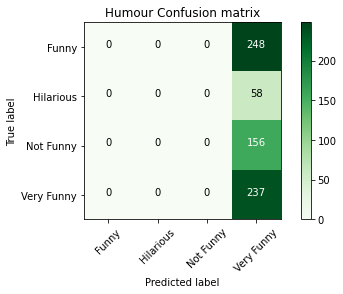

[[344   0   0   0]
 [156   0   0   0]
 [150   0   0   0]
 [ 49   0   0   0]]


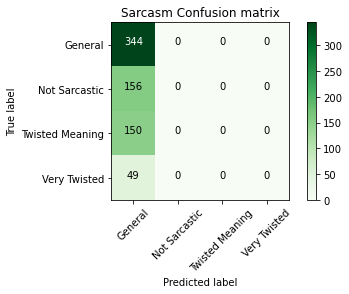

[[  0   1  21   0]
 [  0  16 258   0]
 [  0   9 238   0]
 [  0   7 149   0]]


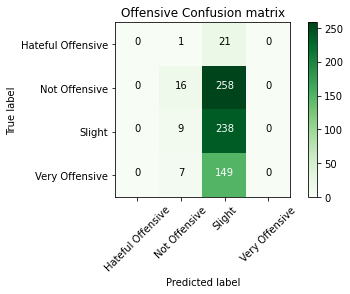

[[  0 241]
 [  0 458]]


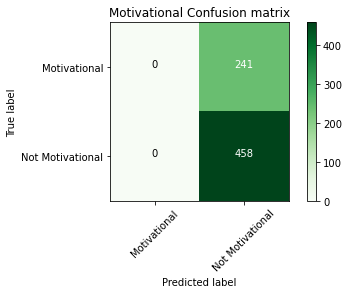

[[  0   0  38   0   0]
 [  0   2 218   0   0]
 [  0   2 313   0   0]
 [  0   0  16   0   0]
 [  0   0 110   0   0]]


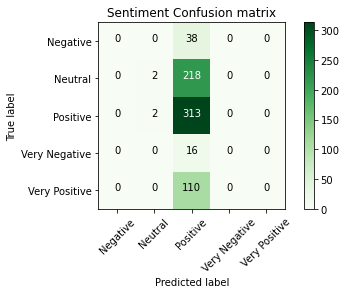

In [77]:
# Compute confusion matrix
humour_cnf_matrix = metrics.confusion_matrix(humour_test_data, preds_humour_label) 
np.set_printoptions(precision=2)
plot_confusion_matrix(humour_cnf_matrix, classes=humour_classes,title='Humour Confusion matrix')


sarcasm_cnf_matrix = metrics.confusion_matrix(sarcasm_test_data, preds_sarcasm_label) 
plot_confusion_matrix(sarcasm_cnf_matrix, classes=sarcasm_classes,title='Sarcasm Confusion matrix')

offensive_cnf_matrix = metrics.confusion_matrix(offensive_test_data, preds_offensive_label) 
plot_confusion_matrix(offensive_cnf_matrix, classes=offensive_classes,title='Offensive Confusion matrix')

mot_cnf_matrix = metrics.confusion_matrix(motivational_test_data, preds_motivational_label) 
plot_confusion_matrix(mot_cnf_matrix, classes=motivational_classes,title='Motivational Confusion matrix')

sentiment_cnf_matrix = metrics.confusion_matrix(overall_sentiment_test_data, preds_sentiment_label) 
plot_confusion_matrix(sentiment_cnf_matrix, classes=sentiment_classes,title='Sentiment Confusion matrix')


---

## Real-time predictions with Image as Input

We can run real-time predictions using any meme image as input - we extract the text from the image using AWS Rekognition APIs and send it to text classification container and we also feed the image as input to image classification container.

In [ ]:
def detect_text(payload):

    client=boto3.client('rekognition')

    response=client.detect_text(Image={'Bytes': payload})
                        
    textDetections=response['TextDetections']
    print ('Detected text\n----------')
    line = ""
    for text in textDetections:
        confidence = float("{:.2f}".format(text['Confidence']))
        if text['Type'] == 'LINE' and confidence > 95.00:
            line += text['DetectedText']
            line += " "
                
    return line


In [ ]:
file_name = 'test.jpg' ##filepath of the image input

with open(file_name, 'rb') as f:
    payload = f.read()
    payload = bytearray(payload)

In [ ]:
response = runtime.invoke_endpoint(EndpointName=endpoint_name, 
                                   ContentType='application/x-image',
                                   TargetContainerHostname = img_ContainerHostname,
                                   Body=payload)
result = response['Body'].read()
# result will be in json format and convert it to ndarray
result = json.loads(result)
image_pred = list(np.around(np.array(result),3))

In [ ]:
line=detect_text(payload)
clean_text = process_text_line(line)
tokenized_sentences = [' '.join(nltk.word_tokenize(clean_text))]
payload = {"instances" : tokenized_sentences, "configuration": {"k": 19}}

In [ ]:
response = runtime.invoke_endpoint(EndpointName=endpoint_name, 
                                   ContentType='application/json',
                                   TargetContainerHostname = nlp_ContainerHostname,
                                   Body=json.dumps(payload))

result = response['Body'].read()
# result will be in json format and convert it to ndarray
result = json.loads(result)
text_pred = sortbylabels(results)

In [ ]:
# find average of NumPy arrays
ensemble_prediction = 0.5* np.array(image_pred) + 0.5 *np.array(text_pred)

##### Run the command below to delete endpoints once you are done.

In [ ]:
sage.delete_endpoint(EndpointName=endpoint_name)